# Decoy Effect Model - Version 1.0

March 12 2023

Field variables, `MV` and `Drug`, are treated in a matrix instead of agents, this will speed up the simulation quite a bit and optimize scheduling using vectorization



## Model Parameters

In [1]:
import sys
import math
import random
import numpy as np
import pandas as pd
import mesa
import matplotlib.pyplot as plt
import matplotlib.colors as mplc

# Global Functions ################################################################

def diskmask(shape, radius):
    """ Produces a circular mask in the center of a grid
        Args:
            shape: of array grid
            radius: radius of mask
    """
    from skimage.draw import disk
    
    mask = np.zeros(shape)    
    rr, cc = disk((shape[0]/2, shape[0]/2), radius)
    mask[rr, cc] = 1
    
    return mask


def euclid(pos_1, pos_2):
    """ Get the Euclidean distance between two points
        Args:
            pos_1, pos_2: Coordinate tuples
    """
    return math.sqrt((pos_1[0] - pos_2[0])**2 + (pos_1[1] - pos_2[1])**2)


def event_probability(t, t_mean, t_std):
    """ Get the probability of an event from a cdf distribution with mean, std mean
        Args:
            t:      time variable value (eg. age)
            t_mean: mean time of event (eg. life span) 
        
    """
    from scipy.stats import norm
    return norm.cdf(t, loc=t_mean, scale=t_std)


def normalizes_field(M):
    M = np.maximum(M, np.zeros_like(M)) 
    M = np.nan_to_num(M)
    return M
        
        
def laplacian(M):
    """
    Discrete Laplacian using a nine-point stencil (kernel):

          | 0.25 0.50 0.25 |
    D^2 = | 0.50 -3.0 0.50 | 
          | 0.25 0.50 0.25 |

    We can define a factor = (0.5/(|x - x_0| + |y - y_0|) which is 
     - 0.25 for diagonal elements
     - 0.50 for non-diagonal elements
     - undefined for center element (irrelevant)

    """
    L = -3*M
    L += (0.25)*np.roll(M, (+1, +1), (0, 1)) # top-left neighbor
    L += (0.50)*np.roll(M, (+1,  0), (0, 1)) # top neighbor
    L += (0.25)*np.roll(M, (+1, -1), (0, 1)) # top-left neighbor
    L += (0.50)*np.roll(M, (0,  +1), (0, 1)) # left neighbor
    L += (0.50)*np.roll(M, (0,  -1), (0, 1)) # right neighbor
    L += (0.25)*np.roll(M, (-1, +1), (0, 1)) # bottom_left neighbor
    L += (0.50)*np.roll(M, (-1,  0), (0, 1)) # bottom neighbor
    L += (0.25)*np.roll(M, (-1, -1), (0, 1)) # bottom_right neighbor
    
    return L
    
    
def sigmoid(x, mu, K):
    """ Response function: 
        Args:
            mu: response is linear with slope 'mu' for x small (x->0) 
            K: response saturates at value K for x large (x->inf)  
    """
    return K*(mu*x / (mu*x + K))


def animate(frames, nframes, cmap, norm, moviename, fps = 30):
        
    import matplotlib.animation as animation

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )
    
    snapshots = [ frames[i, :, :] for i in range(nframes - 1) ]

    im = plt.imshow(snapshots[0], interpolation='nearest', aspect='auto', cmap=cmap, norm=norm)

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )
        im.set_array(snapshots[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate_func, 
                                   frames = nframes, interval = 1000 / fps) 
    #plt.show()
    #anim.save( moviename, writer=animation.FFMpegWriter(fps=fps))
    #anim.save(moviename, fps=fps, extra_args=['-vcodec', 'libx264'])
    
    return(anim)
                     

In [2]:
class Params():
    """
    class of simulation parameters
    
    """
    def __init__(self, i = 0, filein = None):
        """
        creates set of parameters with default values
    
        """
        
        # Simulation 
        self.id = i                              # ID of the parameter set
        self.width = 100                         # Width of array grid
        self.height = 100                        # Height of array grid
        self.initial_population_0 = 100          # Initial population of SNVs
        self.initial_population_1 = 50           # Initial population of SHVs
        self.initial_population_2 = 10           # Initial population of RNVs
        self.number_of_steps = 100               # Time length of simulation (in ticks)
        self.tumor_radius = 10                   # Radius of initial tumor  
        
        # Dossage controls
        self.drug_dossage = 100                  # Drug dossage per site  
        self.drug_dossage_time = 1000            # Time period for new dossage (+/- 1%)

        # Cell dynamics 
        self.life_span = 100                     # Age of cells natural death (+/- 10%)
        self.division_age = 5                    # Base age of cell division (+/- 5%)
        self.fitness_cost_0 = 1                  # Fitness factor for SNVs (multiply division age)
        self.fitness_cost_1 = 1.5                # Fitness factor for SHVs (multiply division age)
        self.fitness_cost_2 = 2                  # Fitness factor for RNVs (multiply division age)
        self.replacement_prob = 0.1              # Probability of cell replacement  
        self.kill_cell = 5                       # Killing threshold of cell by the drug
        
        # Vesicle dynamics
        self.mv_prod_0 = 0                       # Background vesicule production per cell per tick
        self.mv_prod_drug = 1                    # Vesicule production per cell per tick per unit drug
        self.mv_prod_max = 10                    # Maximun vesicle production per cell per tick
        self.kill_mv = 0.1                       # Max drug per MV (MV is `killed` when saturated)
        self.diff_mv = 0.1                       # Rate of MV difussion (per tick per site)
        self.mv_max = 50                         # Maximun MVs in grid site (MV saturation)
        
        # Drug dynamics
        self.drug_abs_cell = 0.5                 # Rate of drug absorption per cell per tick
        self.drug_abs_mv = 0.1                   # Rate of drug absorption per vesicle per tick
        self.drug_decay = 0.1                    # Rate of drug decay per tick    
        self.diff_drug = 0.25                    # Rate of drug difussion (per tick per site)    
        self.drug_max = 50                       # Maximune drug in grid site (drug saturation)
        
        # if a parameter filename is given, read parameters from it (index i)
        if filein is not None:
            self.read_parameters_from_file(filein, i)
        

    def get_parameter(self, param):

        return(getattr(self, param))

    def set_parameter(self, param, value):

        setattr(self, param, value)

    def read_parameters_from_file(self, fil, i):
        
        parameters = vars(self)
        
        tbl = pd.read_csv(fil)
        
        defaulted = [p for p in parameters if p not in tbl]
        extra = [p for p in tbl if p not in parameters]
        
        if defaulted:
            print("Attention! parameters: <" + str(defaulted) + \
              "> were not found in parameter table. They will be assigned default values...")
        if extra:
            print("Attention! parameters: <" + str(extra) + \
              "> in parameter table are not valid. They will be ignored...")
        
        for col in tbl:
            if col in parameters:
                self.set_parameter(col, tbl[col].values[i])
        
        
    def read_parameters_from_tbl(self, tbl, i):
        
        parameters = vars(self)
        
        defaulted = [p for p in parameters if p not in tbl]
        extra = [p for p in tbl if p not in parameters]
        
        if defaulted:
            print("Attention! parameters: <" + str(defaulted) + \
              "> were not found in parameter table. They will be assigned default values...")
        if extra:
            print("Attention! parameters: <" + str(extra) + \
              "> in parameter table are not valid. They will be ignored...")
        
        for col in tbl:
            if col in parameters:
                self.set_parameter(col, tbl[col].values[i])
                
                

## Simple visualization

## Retreive data saved in previous run

### Cells visualization

sim_0001


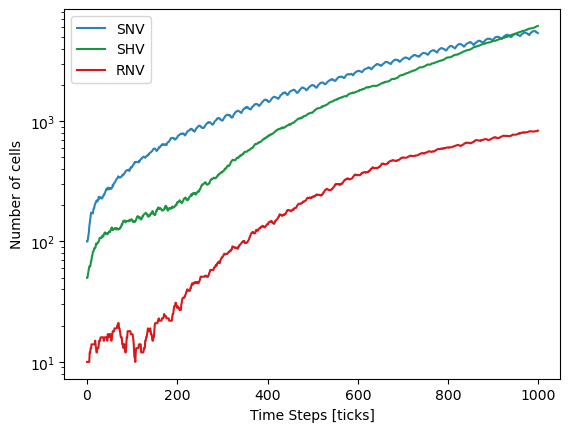

In [57]:
params_tbl = pd.read_csv('parameters.csv')
params = Params()

i = 0   # index of result of interest
params.read_parameters_from_tbl(params_tbl , i)
simid = "sim_" + "{:04d}".format(params.id) 
print(simid)
outfile = "simulations/" + simid + ".npz"

aux = np.load(outfile)
cell_grid = aux['cell_grid'] 
mv_grid = aux['mv_grid'] 
drug_grid = aux['drug_grid'] 
t_series = pd.DataFrame(aux['t_series'], columns = ['Step','SNVs','SHVs', 'RNVs'])
cell_table = pd.DataFrame(aux['cell_table'], columns = ['time','cell_id','phenotype', 
                                                        'age', 'x', 'y', 'drug', 'mvoutput'])

cell_table = cell_table.astype({"time":"int", "cell_id":"int", 
                                "phenotype":"int","age":"int", 
                                "x":"int", "y":"int"})

cell_bins = [-1, 0, 1, 2, 3]
cell_colors = ("#000000", "#2b83ba", "#1a9641", "#d7191c")
cell_labels = ("", "SNV", "SHV", "RNV")

cmap = mplc.ListedColormap(cell_colors)
norm = mplc.BoundaryNorm(cell_bins, len(cell_bins))

%matplotlib inline

N = len(t_series)

ax = plt.subplot(1,1,1)
ax.plot(t_series.Step, t_series.SNVs, label=cell_labels[1], color=cell_colors[1])
ax.plot(t_series.Step, t_series.SHVs, label=cell_labels[2], color=cell_colors[2])
ax.plot(t_series.Step, t_series.RNVs, label=cell_labels[3], color=cell_colors[3])
ax.set_xlabel("Time Steps [ticks]")
ax.set_ylabel("Number of cells")
ax.set_yscale('log')
ax.legend()
plt.show()

## Cell-level stats

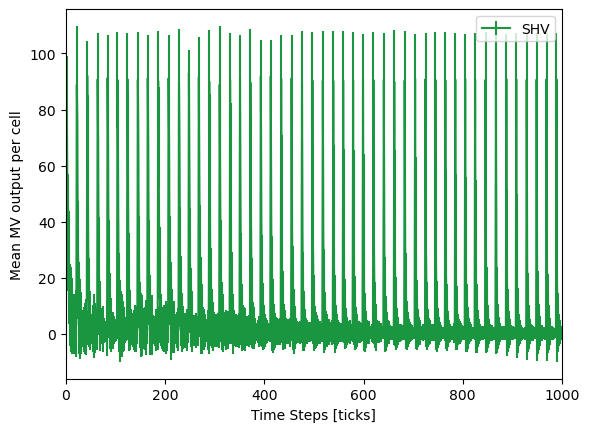

In [58]:
aux = (cell_table.groupby(['time', 'phenotype'])['mvoutput'].agg(['mean', 'std'])
       .set_axis(['mvoutput_mean', 'mvoutput_std'], axis=1)
       .reset_index()
       [['time', 'phenotype', 'mvoutput_mean', 'mvoutput_std']])

maxt = np.max(aux.loc[aux['phenotype']==1, 'time'])

ax = plt.subplot(1,1,1)
indx = aux['phenotype'] == 1
ax.errorbar(aux.time[indx], aux.mvoutput_mean[indx], yerr=aux.mvoutput_std[indx],
            color=cell_colors[2], label=cell_labels[2])
ax.set_xlabel("Time Steps [ticks]")
ax.set_ylabel("Mean MV output per cell")
ax.set_xlim([0, maxt+1])
ax.legend()
plt.show()

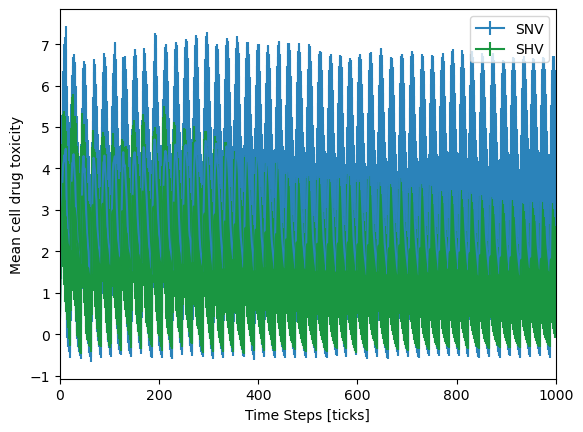

In [59]:
aux = (cell_table.groupby(['time', 'phenotype'])['drug'].agg(['mean', 'std'])
       .set_axis(['drug_mean', 'drug_std'], axis=1)
       .reset_index()
       [['time', 'phenotype', 'drug_mean', 'drug_std']])

maxt = np.max(aux.loc[aux['phenotype']<2, 'time'])

ax = plt.subplot(1,1,1)
for phen in range(2):
    indx = aux['phenotype'] == phen
    ax.errorbar(aux.time[indx], aux.drug_mean[indx], yerr=aux.drug_std[indx],
                color=cell_colors[phen+1], label=cell_labels[phen+1])
ax.set_xlabel("Time Steps [ticks]")
ax.set_ylabel("Mean cell drug toxicity")
ax.set_xlim([0, maxt+1])
ax.legend()
plt.show()

## Grid display

<IPython.core.display.Javascript object>


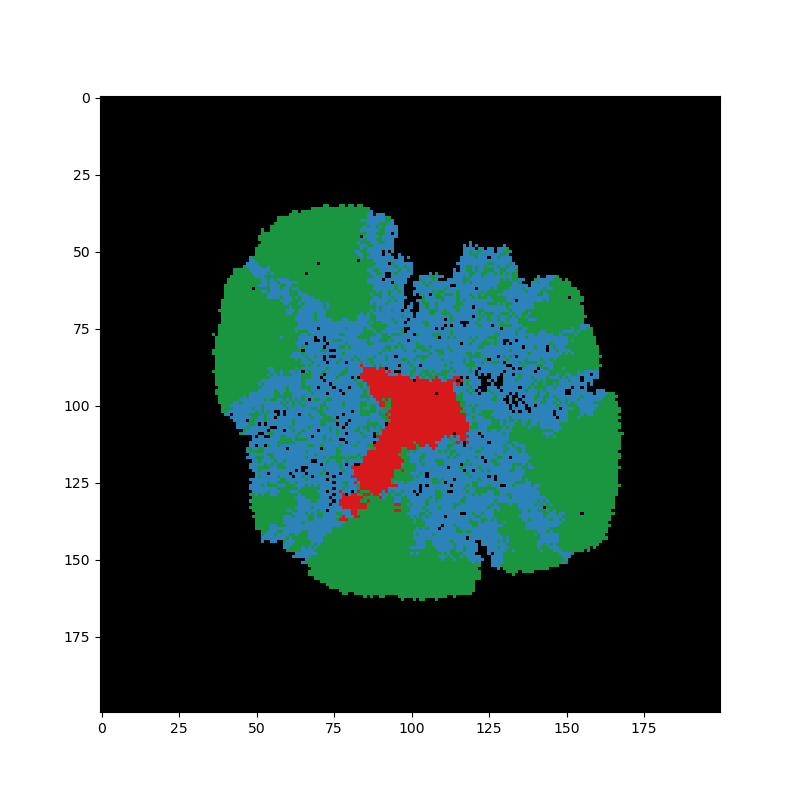

In [60]:
# We need `notebook` for the anim to render in the notebook
%matplotlib notebook

#plt.imshow(cells[-1, :, :], interpolation='nearest', cmap=cmap, norm=norm)
#plt.show()

anim = animate(cell_grid, N, cmap, norm,  "cells_"+ simid + ".mp4")

<IPython.core.display.Javascript object>


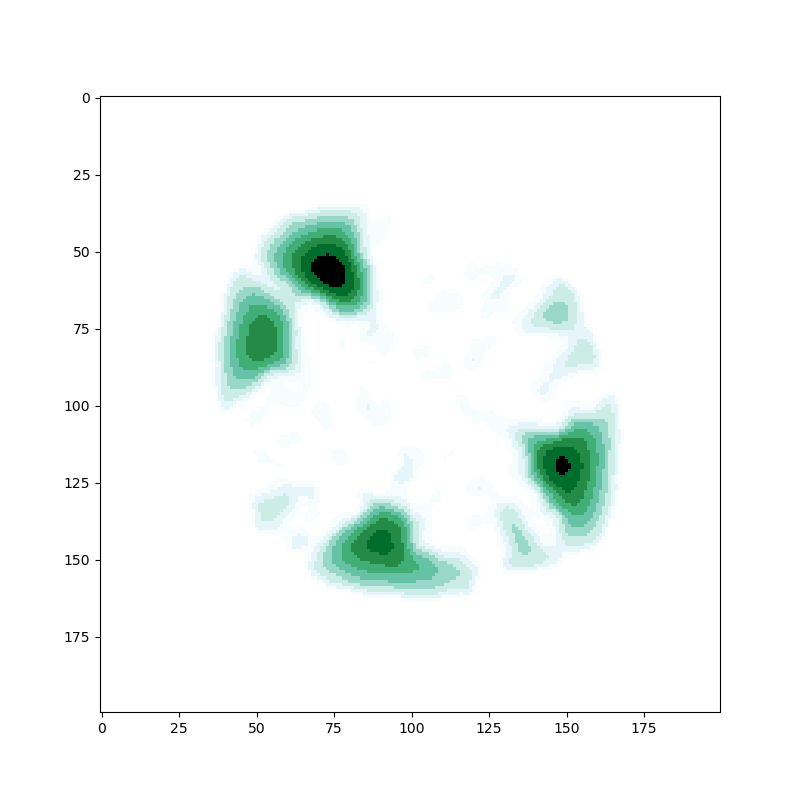

In [61]:
mv_bins = np.linspace(0, np.max(mv_grid), 11, endpoint=True)
#mv_bins = np.linspace(0, MAX_MVS_SITE, 11, endpoint=True)
mv_colors = ("#ffffff", "#f7fcfd", "#e5f5f9", "#ccece6", "#99d8c9",
             "#66c2a4", "#41ae76", "#238b45", "#006d2c", "#00441b", "#000000")

cmap = mplc.ListedColormap(mv_colors)
norm = mplc.BoundaryNorm(mv_bins, len(mv_bins))

#plt.imshow(mv_grid[-1, :, :], interpolation='nearest', cmap=cmap, norm=norm)
#plt.show()

anim = animate(mv_grid, N, cmap, norm,  "mvs_"+ simid + ".mp4")

<IPython.core.display.Javascript object>


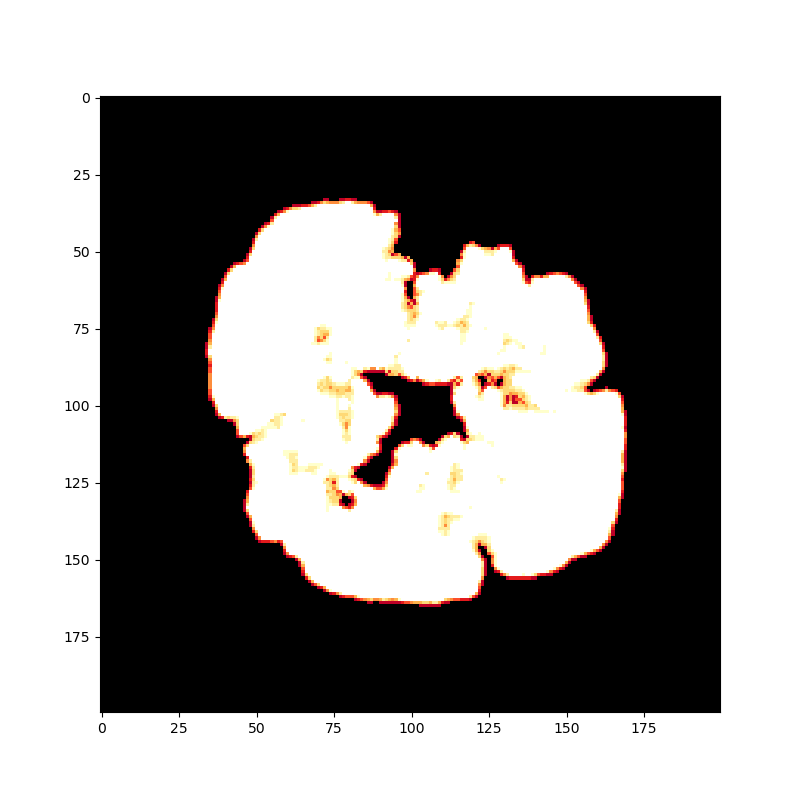

In [62]:
drug_bins = np.linspace(0, np.max(drug_grid), 11, endpoint=True)
#drug_bins = np.linspace(0, MAX_DRUG_SITE, 11, endpoint=True)
drug_colors = ("#ffffff", "#ffffcc", "#ffeda0", "#fed976", "#feb24c", 
               "#fd8d3c", "#fc4e2a", "#e31a1c", "#bd0026", "#800026", "#000000")

cmap = mplc.ListedColormap(drug_colors)
norm = mplc.BoundaryNorm(drug_bins, len(drug_bins))

#plt.imshow(drug_grid[-1, :, :], interpolation='nearest', cmap=cmap, norm=norm)
#plt.show()
anim = animate(drug_grid, N, cmap, norm,  "drugs_"+ simid + ".mp4")

# Using Mesa visualization tools

In [ ]:
def agent_portrayal(agent):
    
    cell_colors = ("#2b83ba", "#1a9641", "#d7191c")

    mv_bins = np.linspace(0, MAX_MVS_SITE, 11, endpoint=True)
    mv_colors = ("#ffffff", "#f7fcfd", "#e5f5f9", "#ccece6", "#99d8c9",
                 "#66c2a4", "#41ae76", "#238b45", "#006d2c", "#00441b", "#000000")

    drug_bins = np.linspace(0, MAX_DRUG_SITE, 11, endpoint=True)
    drug_colors = ("#ffffff", "#ffffcc", "#ffeda0", "#fed976", "#feb24c", 
                   "#fd8d3c", "#fc4e2a", "#e31a1c", "#bd0026", "#800026", "#000000")

    if agent is None:
        return

    if type(agent) is Cell:
        return {"Color": cell_colors[agent.phenotype],
                "Shape": "rect",
                "Filled": "true",
                "Layer": 2,
                "w": 1,
                "h": 1, }
    
    elif type(agent) is MV:
        return {"Color": mv_colors[np.digitize(agent.amount, mv_bins, right=True)],
                "Shape": "rect",
                "Filled": "true",
                "Layer": 1,
                "w": 1,
                "h": 1, }
    
    elif type(agent) is Drug:
        return {"Color": drug_colors[np.digitize(agent.amount, drug_bins, right=True)],
                "Shape": "rect",
                "Filled": "true",
                "Layer": 0,
                "w": 1,
                "h": 1, }

    return {}


canvas_element = mesa.visualization.CanvasGrid(agent_portrayal, WIDTH , HEIGHT , 600 , 600 )

#chart_element = mesa.visualization.ChartModule([{"Label": "Agent", "Color": "#AA0000"}])

server = mesa.visualization.ModularServer(Decoy, 
                                          #[canvas_element, chart_element],
                                          [canvas_element],
                                          "Decoy Model V.0.0",
                                         {"width":WIDTH, 
                                          "height":HEIGHT, 
                                          "initial_population": INITIAL_POPULATION})

In [ ]:
server.launch()

# MISC helping code

## the event probability function

In [ ]:
################################################################################################

from scipy.stats import norm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
t = np.linspace(0, 2*REPLICATION_AGE, 1000)
ax.plot(t, event_probability(t, REPLICATION_AGE, REPLICATION_AGE/20), color = 'b')
ax.axvline(x = REPLICATION_AGE, color = 'r', ls='--')
ax.axvline(x = (REPLICATION_AGE)*(0.95), color = 'r', ls=':')
ax.axvline(x = (REPLICATION_AGE)*(1.05), color = 'r', ls=':')
ax.axhline(y = 1, color = 'k', ls=':')
ax.axhline(y = 0, color = 'k', ls=':')
ax.axhline(y = 0.5, color = 'k', ls=':')

## the response Sigmoid function

In [ ]:
MAX_DRUG = 100
MAX_MVS = 100
NU_D = 100
NU_0 = 0

fig, ax = plt.subplots(1, 1)
x = np.linspace(0, MAX_DRUG, 1000)
ax.plot(x, sigmoid(x, NU_D, MAX_MVS), color = 'b')
ax.plot(x, NU_D*x, color = 'k')
ax.axhline(y = MAX_MVS, color = 'k', ls=':')
ax.axhline(y = NU_0, color = 'k', ls=':')
ax.axhline(y = 0, color = 'k', ls=':')
ax.axvline(x = 0, color = 'r', ls=':')
ax.set_xlim([0, MAX_DRUG ])
ax.set_ylim([0, MAX_MVS*1.2])

## animation example

In [ ]:
# Usually we use `%matplotlib inline`. However we need `notebook` for the anim to render in the notebook.
%matplotlib notebook

import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.animation as animation


fps = 30
#snapshots = [ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]
snapshots = [ cell_grid[i, :, :] for i in range(100) ]

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

im = plt.imshow(snapshots[0], interpolation='nearest', aspect='auto', cmap=cmap, norm=norm)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(fig, 
                               animate_func, 
                               frames = 100,
                               interval = 1000 / fps)

#anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')


In [ ]:
cell_grid.shape


In [ ]:
cellgrid = np.zeros((decoy_model.grid.width, decoy_model.grid.height))
mvgrid = np.zeros((decoy_model.grid.width, decoy_model.grid.height))
druggrid = np.zeros((decoy_model.grid.width, decoy_model.grid.height))

for pos in decoy_model.grid.coord_iter():
    agents, x, y = pos
    
    cell = [agent.phenotype for agent in agents if type(agent) is Cell]
    if (len(cell)==0):
        cell = [-1]
    mv = [agent.amount for agent in agents if type(agent) is MV]
    drug = [agent.amount for agent in agents if type(agent) is Drug]
    
    cellgrid[y][x] = cell[0]
    mvgrid[y][x] = mv[0]
    druggrid[y][x] = drug[0]
    